<a href="https://colab.research.google.com/github/WCSCourses/CRISPR_Informatics_2024/blob/jb63_screening_module/02_crispr_counts_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processing counts data from a CRISPR screen

## Table of contents
1. [Introduction and aims](#intro)
2. [Step 1: Installing software for our session](#step1)
3. [Step 2: Exploring the raw counts dataset](#step2)
4. [Step 3: Generating log fold-changes for genes](#step3)
5. [Step 4: Screen validatation](#step4)
7. [Summary](#summary)
8. [References](#references)

-----

## Introduction and aims
Thee aim of this practical class is to introduce you to some of the concepts involved in the analysis of a pooled CRISPR screen. Will we take a set of pre-generated CRISPR counts data and use tools like R and MAGECK to explore the dataset. Next, we will identify essential genes in a cell line and introduce some of the tools for investigating CRISPR sequencing datasets.


As you covered earlier in the day, CRISPR screens are a powerful functional genomics method that can help us to identify genetic interactions. Since it is so adaptable, the CRISPR-Cas9 system can be configured to

At Wellcome Trust Sanger Institute, we participate in the large scale CRISPR screening of cancer cell lines for initiatives such as [DepMap](https://depmap.sanger.ac.uk/documentation/datasets/wg-crispr-knockout/) to better understand the genetic dependencies of cancer. THis  

![Figure 1. Project score ](figures/project_score.png)


HAP1 cell line a near-haploid human cell line [HAP1 paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10020200/#B2). Popular model for gene editing experiments avoid some of the the challenges associated with editing diploid - mixed penetrance of genome editing.

![Figure 2. HAP1 karyotype]("figures/HAP1_cell_karyotype.png")


Screen involves is a simple experiment just 4 samples: T0 is a pre-screen sample - generated from material where CRISPR-Cas9 cutting has not occured yet - and T18 A, B and C are replicates collected 18 days after the screen began.



![Figure 3. Screen demo]("figures/)





## Step 1: Installing software for our session

In order to install some of the tools we will be using in the session, we'll first have to add condacolab. Condacolab lets us manage software packgewithin a google colab session.

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:12
🔁 Restarting kernel...


After this, we'll load an extension for the collab notebook that lets us execute R code within collab notebook cells.

In [2]:
%load_ext rpy2.ipython

Now, any cells that contain the `%%R` tag at the start will be executed within an R environment.

** Note: any lines of code that contain an `!` at the start will be executed in bash (the default scripting language in a terminal).

We'll start by loading a couple of R dependencies into the collab session. For those newer to R, this notebook loads the `tidyverse` meta package: a set of tools that extend "base" R to make data-wrangling and exploration more enjoyable. The code also makes use of the `|>` pipe functionality in R, which simplifies multi-step data manipulation.  

*Note: Some of you might recognise `|>`'s progenitor – `%>%` – which was prevalent in older versions of R.*

In [14]:
%%R
# Load our dependencies
install.packages("ggrepel")
library(tidyverse)
library(ggrepel)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/ggrepel_0.9.6.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 149970 bytes (146 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[writ

-------
## Step 2: Exploring the raw counts dataset

Let's start by reading the counts file we'll be looking at input R. We'll display the dataframe that this produces:


In [5]:
%%R
input_file <- read_tsv("reads_hap1.txt")
input_file

Rows: 71090 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): SEQUENCE, GENE
dbl (4): HAP1_T0, HAP1_T18A, HAP1_T18B, HAP1_T18C

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 71,090 × 6
   SEQUENCE             GENE  HAP1_T0 HAP1_T18A HAP1_T18B HAP1_T18C
   <chr>                <chr>   <dbl>     <dbl>     <dbl>     <dbl>
 1 ACTGGCGCCATCGAGAGCCA A1BG      239       245       230        62
 2 CAAGAGAAAGACCACGAGCA A1BG     1647       415       313       394
 3 GCTCAGCTGGGTCCATCCTG A1BG     1480       492       388       415
 4 GTCGAGCTGATTCTGAGCGA A1BG      888       387       297       202
 5 AGTTATGTTAGGTATACCCG A1CF      266       176       327       328
 6 ATGACTCTCATACTCCACGA A1CF      294       183       254       131
 7 GGTGCAGCATCCCAACCAGG A1CF      307       314       143       186
 8 TGCGCTGGACCAG


This dataframe has several columns, one representing the CRISPR guide sequences we used in the screen, one representing the genes that they target and several representing samples in the experiment (`HAP1_T0`, `HAP1_T18A` etc.)

The `HAP1` in these sample names reflects the cell line we screened in the experiment and the T<X> reflects the timepoint the sample was collected at. This a simple experiment with just 4 samples: T0 is a pre-screen sample - generated from material where CRISPR-Cas9 cutting has not occured yet - and T18 A, B and C are replicates collected 18 days after the screen began.

--------
### Questions
One thing you might notices about the dataframe is that there are multiple guides sequences per gene.
- Why do you think this might be?

In some cases the sequences you can see above have counts that can vary quite widely between the T18 A, B and C replicates.

- Can you think of any explanations for this variability?


-------
[**Back to top**](#top)

## Reformating our data

The dataframe we've created has several columns represnting guide RNA counts. For downstream analysis in R it can often be helpful to "wrangle" data into a [tidy format](https://r4ds.had.co.nz/tidy-data.html). We'll do that here by collapsing all of our HAP1 columns into one with a command called a pivot.


In [ ]:
guide_counts <- input_file |>
pivot_longer(cols = contains("HAP1"),
                             values_to = "counts",
                             names_to = "sample")

We can glance at the first few lines of our refomatted dataset (which will be easier to explore in R) with:

In [8]:
%%R
head(guide_counts)

# A tibble: 6 × 4
  SEQUENCE             GENE  sample    counts
  <chr>                <chr> <chr>      <dbl>
1 ACTGGCGCCATCGAGAGCCA A1BG  HAP1_T0      239
2 ACTGGCGCCATCGAGAGCCA A1BG  HAP1_T18A    245
3 ACTGGCGCCATCGAGAGCCA A1BG  HAP1_T18B    230
4 ACTGGCGCCATCGAGAGCCA A1BG  HAP1_T18C     62
5 CAAGAGAAAGACCACGAGCA A1BG  HAP1_T0     1647
6 CAAGAGAAAGACCACGAGCA A1BG  HAP1_T18A    415


Now that CRISPR counts data like this data frame, I'd recommend visualise it so that you can better understand whether the samples meets you expectations.

For a typical genome wide CRISPR screen, would hope that all of the guides seqeunces are observed in our sample (with counts >0) and that there is sufficient coverage for each guide in the library for us to perform statistical tests in downstream tools like MAGECK. Let's check this now:

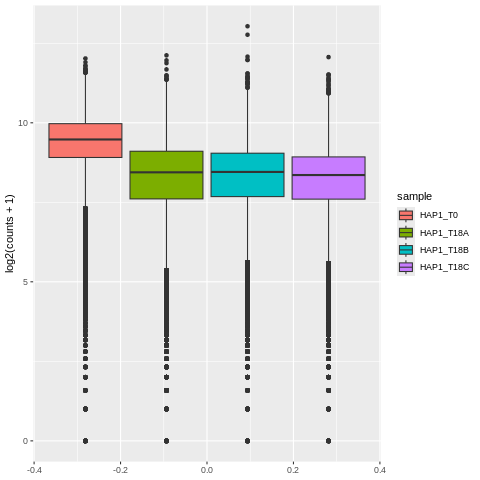

In [11]:
%%R
# You can represent this dataset condensed way with a boxplot - highlighting the mean, IQR
# range of guide counts in the dataset and any guides with extremely high or low counts.
ggplot(guide_counts, aes(y=log2(counts+1))) +
geom_boxplot(aes(fill = sample))

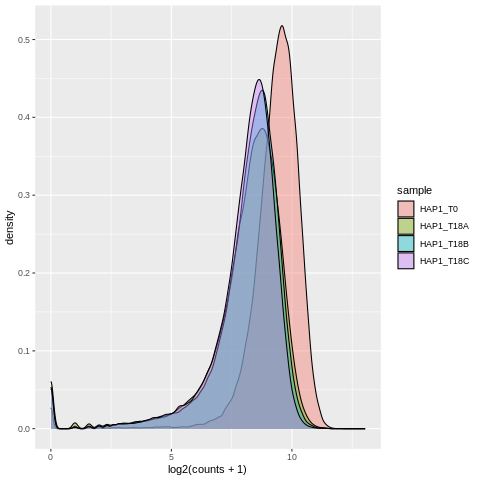

In [14]:
%%R
# Alternatively plot the distribution of counts across the different guides in the screen
ggplot(guide_counts, aes(x=log2(counts+1))) +
geom_density(aes(fill = sample), alpha = 0.4)

### Questions
1. Counts QC
- What do you estimate is the mean number of counts per guide RNA in our samples?
- How many counts-per-guide do you think would be sufficient for us to perform a CRISPR knockout screen?

2. Sample QC
	- How might you identify poor-quality or outlier samples in a dataset like this? Are you aware of any techniques for this?

---
[↥ **Back to top**](#top)



------
## Step 3: Generating log fold-changes for genes

Since our data looks of suitable quality for downstream processing, we will now try to find out which genes in the HAP1 cell-line depends on for it's survival by looking for  over the course of the experiemnt.

To do this we will use [MAGECK](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0554-4) a popular tool for CRISPR counts analysis that uses a negative binomial (NB) model to identify significantly depleted

In brief, MAGECK is going to
- Median normalise the dataset (to account for differnces in sequencing depth)
- Model the mean-variance trend in the dataset (to better handle guides with different mean counts)
- Perform statistical testing and appropriate corrections (to identify significantly altered guides)

This will give us p-values and log2fold changes for individual **guides** in the dataset.


We can start by installing MAGECK through conda. To avoid a long message about the installation process the cell below has had it's output silenced by redirecting it to a "black-hole" in the computer.




In [16]:
!conda install bioconda::mageck &> /dev/null

Once the above installation has finished we should be able to check that MAGECK is installed and look at the tool's options using a `-h` flag


In [17]:
!mageck -h

usage: mageck test [-h] -k COUNT_TABLE (-t TREATMENT_ID | --day0-label DAY0_LABEL) [-c CONTROL_ID]
                   [--paired] [--norm-method {none,median,total,control}]
                   [--gene-test-fdr-threshold GENE_TEST_FDR_THRESHOLD]
                   [--adjust-method {fdr,holm,pounds}]
                   [--variance-estimation-samples VARIANCE_ESTIMATION_SAMPLES]
                   [--sort-criteria {neg,pos}] [--remove-zero {none,control,treatment,both,any}]
                   [--remove-zero-threshold REMOVE_ZERO_THRESHOLD] [--pdf-report]
                   [--gene-lfc-method {median,alphamedian,mean,alphamean,secondbest}]
                   [-n OUTPUT_PREFIX]
                   [--control-sgrna CONTROL_SGRNA | --control-gene CONTROL_GENE]
                   [--normcounts-to-file] [--skip-gene SKIP_GENE] [--keep-tmp]
                   [--additional-rra-parameters ADDITIONAL_RRA_PARAMETERS] [--cnv-norm CNV_NORM]
                   [--cell-line CELL_LINE] [--cnv-est CNV_EST]

Now we are ready to run MAGECK.

In [23]:
!mageck test -k reads_hap1.txt -c 0 -t 1,2,3 -n all_vs_control --normcounts-to-file


INFO  @ Tue, 10 Sep 2024 09:59:31: Parameters: /usr/local/bin/mageck test -k reads_hap1.txt -c 0 -t 1,2,3 -n all_vs_control --normcounts-to-file 
INFO  @ Tue, 10 Sep 2024 09:59:31: Welcome to MAGeCK v0.5.9.5. Command: test 
INFO  @ Tue, 10 Sep 2024 09:59:31: Loading count table from reads_hap1.txt  
INFO  @ Tue, 10 Sep 2024 09:59:31: Processing 1 lines.. 
INFO  @ Tue, 10 Sep 2024 09:59:32: Loaded 71090 records. 
INFO  @ Tue, 10 Sep 2024 09:59:32: Loading Rnw template file: /usr/local/lib/python3.10/site-packages/mageck/test_report.Rmd. 
INFO  @ Tue, 10 Sep 2024 09:59:32: Loading R template file: /usr/local/lib/python3.10/site-packages/mageck/plot_template.RTemplate. 
INFO  @ Tue, 10 Sep 2024 09:59:32: Loading R template file: /usr/local/lib/python3.10/site-packages/mageck/plot_template_indvgene.RTemplate. 
INFO  @ Tue, 10 Sep 2024 09:59:32: Loading Rnw template file: /usr/local/lib/python3.10/site-packages/mageck/plot_template.Rnw. 
INFO  @ Tue, 10 Sep 2024 09:59:32: Treatment samples:

In [31]:
  %%R
non_essential <- read_tsv("/content/NEGv1.txt") |>
select(GENE) |>
mutate(type = "non-essential")

essential <- read_tsv("/content/CEGv2.txt") |>
select(GENE) |>
mutate(type = "essential")


essentiality_class <- bind_rows(non_essential, essential)


Rows: 927 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): GENE, HGNC_ID
dbl (1): ENTREZ_ID

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 684 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): GENE, HGNC_ID
dbl (1): ENTREZ_ID

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Error in `group_by()`:
! Must group by variables found in `.data`.
✖ Column `type` is not found.
Run `rlang::last_trace()` to see where the error occurred.

Error in group_by(plot_data, type) : 
✖ Column `type` is not found.


## Validating the results of a screen

In order to have confidence that CRISPR-Cas9 is cutting and selecting against essential genes in your experiment many CRISPR libraries include a set of common essential genes (CEGs) and non-essential genes (NEG).

This positive and negative control set can be expected to deplete (CEGs) and remain constant (NEGs).

One effective way to check the success of a screen is to use a summary stastistic that descibed Null normalised mean difference (NNMD).

In [39]:
%%R
plot_data <- read_tsv("/content/sample1.HAP1_T18A_vs_HAP1_T0.gene_summary.txt")

annotated_data <- left_join(plot_data, essentiality_class, by = c("id" = "GENE"))

Rows: 18055 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): id
dbl (13): num, neg|score, neg|p-value, neg|fdr, neg|rank, neg|goodsgrna, neg...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [53]:
%%R
  # Calculate nnmd
  nnmd <- annotated_data |>
    dplyr::rename(LFC = `neg|lfc`) |>
    group_by(type) |>
    summarise(mean_lfc = mean(LFC), sd_lfc = sd(LFC)) |>
    pivot_wider(names_from = type,
                values_from = c(mean_lfc, sd_lfc)) |>
    mutate(nnmd = (`mean_lfc_essential` - `mean_lfc_non-essential`) /
                 `sd_lfc_non-essential`) |>
    mutate(nnmd_label = sprintf('NNMD = %.2f', nnmd))
  nnmd

# A tibble: 1 × 8
  mean_lfc_essential `mean_lfc_non-essential` mean_lfc_NA sd_lfc_essential
               <dbl>                    <dbl>       <dbl>            <dbl>
1              -3.01                    0.157      -0.112             1.65
# ℹ 4 more variables: `sd_lfc_non-essential` <dbl>, sd_lfc_NA <dbl>,
#   nnmd <dbl>, nnmd_label <chr>


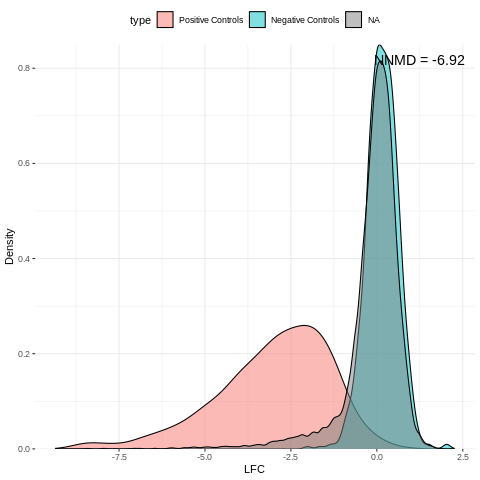

In [54]:

%%R
ggplot(annotated_data, aes(x = `neg|lfc`, fill = type)) +
          geom_density(alpha = 0.5) +
          labs(x = "LFC", y = "Density") +
          theme_bw() +
          theme(legend.position = "top", panel.border = element_blank()) +
          scale_fill_discrete(
            labels = c("Positive Controls", "Negative Controls")
          ) +
          scale_y_continuous(expand = c(0, 0)) +
          annotate(
            "text", x = Inf, y = Inf, label = nnmd[["nnmd_label"]],
            hjust = 1.1, vjust = 2, size = 5, colour = "black"
          )

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/ggrepel_0.9.6.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 149970 bytes (146 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[writ

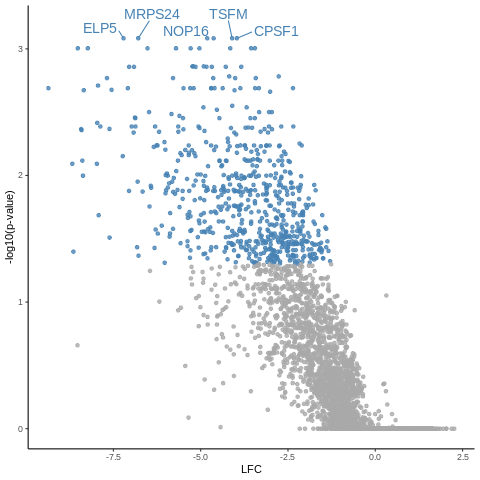

In [61]:

%%R
library(ggrepel)
gene_summary <- annotated_data |>
        mutate(Significant = ifelse(`neg|fdr` < 0.05, "Yes", "No"))

    gene_summary_labels <- gene_summary |>
        filter(`neg|fdr` < 0.05) |>
        head(5)

ggplot(gene_summary, aes(x = `neg|lfc`, y = -log10(`neg|fdr`),
                                 label = id, color = Significant)) +
                geom_point(alpha = 0.8) +
                geom_text_repel(data = gene_summary_labels, aes(label = id),
                        size = 5, nudge_y = 0.1,
                        force = 10, max.overlaps = Inf) +
                scale_color_manual(values = c("darkgrey", "steelblue")) +
                theme_bw() +
                theme(legend.position = "none",
                        panel.grid.major = element_blank(),
                        panel.grid.minor = element_blank(),
                        panel.border = element_blank(),
                        axis.line = element_line(color = "black"),
                        axis.line.x.top = element_blank(),
                        axis.line.y.right = element_blank()) +
                labs(x = "LFC", y = "-log10(p-value)")



## Post processing


In cancer cells, where genomic alterations are widespread, copy number changes

Demonstrated that targeting Cas9 to regions where there are copy number gains results in multiple DNA double-strand breaks, thus inducing larger gene-independent DNA-damage response and a phenotype of G2 cell-cycle arrest3




[CRISPRcleanR](https://www.sanger.ac.uk/tool/crisprcleanr/) applies circular binary segmentation algorithm to identify genomic regions where sgRNA impact is correlated.

Unlikely that contigous genes will be equally essential - instead possible that difference is due to a copy number alteration

In [9]:
!git clone https://github.com/hart-lab/bagel

fatal: destination path 'bagel' already exists and is not an empty directory.
archive			NEGv1.txt
BAGEL.py		Network_STRING_v10.txt
BAGEL-v2-tutorial.html	pan-species-control-essentials-50genes.txt
CEG_mouse.txt		pan-species-control-nonessentials-50genes.txt
CEGv2.txt		pipeline-script-example
data			precalc_library_alignment_info.py
LICENSE			README.md
NEG_mouse.txt		reads_hap1.txt


In [13]:
!conda install click
!./bagel/BAGEL.py

Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.7.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - click


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.8.30  |       hbcca054_0         155 KB  conda-forge
    certifi-2024.8.30          |     pyhd8ed1ab_0         160 KB  conda-forge
    click-8.1.7                |unix_pyh707e725_0          82 KB  conda-forge
    libgcc-14.1.0              |       h77fa898_1         827 KB  conda-forge
    libgcc-ng-14.1.0           |       h69a702a_1          51 KB  conda-forge
    libgomp-14.1.0             |       h77fa898_1         449 KB  conda-forge
    openssl-3.3.2  

That's it for today! In many ways we've only just started, we might want to look at filtering guides out of our dataset, identifying problematic samples using tools like PCA and perfoming associations testing on our guides.

Stay tuned and see you next time!

## References

- [Integrated cross-study datasets of genetic dependencies in cancer](https://www.nature.com/articles/s41467-021-21898-7)

- [Extracting Biological Insights from the Project Achilles Genome-Scale CRISPR Screens in Cancer Cell Lines](https://www.biorxiv.org/content/10.1101/720243v1)

- Aguirre A.J., Meyers R.M., Weir B.A., et al. Genomic copy number dictates a gene-independent cell response to CRISPR-Cas9 targeting. Cancer Discov June 3 2016 DOI: 10.1158/2159-8290.CD-16-0154

- BAGEL: a computational framework for identifying essential genes from pooled library screens. Traver Hart and Jason Moffat. BMC Bioinformatics, 2016 vol. 17 p. 164.